In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()

Num GPUs Available:  1


True

In [2]:
import pandas as pd
import numpy as np
from keras import initializers
from keras import regularizers
from keras import constraints
from keras.layers import Dot, Softmax, Layer, Reshape
import tensorflow as tf

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense, Input, Concatenate, Softmax, Multiply
from sklearn.preprocessing import StandardScaler
import tensorflow.keras.backend as K

from keras.layers import Layer, Dot, Softmax
import keras.backend as K
from tensorflow.keras.layers import Bidirectional
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('display.max_column', 50)

In [3]:
def feature_engineer(dataset_df, time_interval):
    dataset_df['elapsed_time_bin'] = (dataset_df['elapsed_time'] // time_interval).astype(int)

    for col in CATEGORICAL_COLS:
        # Count occurrences for categorical columns
        dataset_df[col] = dataset_df.groupby(['session_id', 'elapsed_time_bin', col])[col].transform('count')

    for col in NUMERICAL_COLS:
        # Calculate median for numerical columns
        dataset_df[col] = dataset_df.groupby(['session_id', 'elapsed_time_bin'])[col].transform('median')

    # Drop duplicate rows to keep only unique combinations of session_id, elapsed_time_bin
    dataset_df.drop_duplicates(subset=['session_id', 'elapsed_time_bin'], inplace=True)

    return dataset_df

In [4]:
trainset = pd.read_csv("./misc/aggregated_100000.csv")

In [55]:
trainset.head()

,Unnamed: 0,session_id,elapsed_time,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,tunic_mistake,plaque_mistake,businesscards_mistake,reader_mistake,event_name_cutscene_click,event_name_map_click,event_name_map_hover,event_name_navigate_click,event_name_notebook_click,event_name_notification_click,event_name_object_click,event_name_object_hover,event_name_observation_click,event_name_person_click,name_close,name_next,name_open,...,text_fqid_tunic.drycleaner.frontdesk.block_0,text_fqid_tunic.library.frontdesk.block_badge,text_fqid_tunic.library.microfiche.block_0,text_fqid_tunic.library.frontdesk.block_badge_2,text_fqid_tunic.humanecology.frontdesk.block_1,text_fqid_tunic.drycleaner.frontdesk.block_1,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,elapsed_time_bin
0,0,20090312431273200,221485,0.450004,0.418348,0.221701,0.263108,2,2,2,2,2,1,2,2,1,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,2
1,81,20090312431273200,300382,0.496753,0.438730,0.219337,0.212174,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,3
2,201,20090312431273200,402718,0.431047,0.403963,0.168786,0.186914,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,4
3,296,20090312433251036,266883,0.545574,0.403541,0.299557,0.259049,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,2
4,320,20090312433251036,300411,0.445593,0.475147,0.193776,0.254622,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1,3


In [5]:
train_labels = pd.read_csv("./data/train_labels.csv")
print(f"Loading {train_labels.shape[0]} labels.")

print(f"Preprocessing session IDs...")

train_labels['session'] = train_labels.session_id.apply(lambda x: int(x.split('_')[0]) )
train_labels['q'] = train_labels.session_id.apply(lambda x: int(x.split('_')[-1][1:]) )

print(f"Labels contains {train_labels['session'].nunique()} sessions with answers to {train_labels['q'].nunique()} questions which is overall {train_labels.shape[0]} rows.")

train_labels["session_id"] = train_labels["session"]
train_labels = train_labels[["session_id", "q", "correct"]]
train_labels[["session_id", "q", "correct"]].head()
print("Creating pivot table...")
pivot_df = train_labels.pivot_table(index='session_id', columns='q', values='correct', aggfunc='first')
# Rename columns to 'q' followed by the question number
pivot_df.columns = ['q' + str(col) for col in pivot_df.columns]
# Fill NaN values with 0 if needed
pivot_df = pivot_df.fillna(0).reset_index()
pivot_df.head()

Loading 424116 labels.
Preprocessing session IDs...
Labels contains 23562 sessions with answers to 18 questions which is overall 424116 rows.
Creating pivot table...


,session_id,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18
0,20090312431273200,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1
1,20090312433251036,0,1,1,1,0,1,1,0,1,0,0,1,0,1,0,1,0,1
2,20090312455206810,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
3,20090313091715820,0,1,1,1,1,0,1,1,1,0,0,1,0,1,0,1,1,1
4,20090313571836404,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,1,1,1


In [6]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='W',
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='b',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        if mask is not None:
            a *= K.cast(mask, K.floatx())

        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0],  self.features_dim


def f1_metric(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

# This is NN LSTM Model creation
def model_lstm(input_shape):
    # The shape was explained above, must have this order
    inp = Input(shape=(input_shape[1], input_shape[2],))
    # This is the LSTM layer
    # Bidirecional implies that the 160 chunks are calculated in both ways, 0 to 159 and 159 to zero
    # although it appear that just 0 to 159 way matter, I have tested with and without, and tha later worked best
    # 128 and 64 are the number of cells used, too many can overfit and too few can underfit
    x = Bidirectional(LSTM(10, return_sequences=True))(inp)
    # The second LSTM can give more fire power to the model, but can overfit it too
    # x = Bidirectional(LSTM(64, return_sequences=True))(x)
    # Attention is a new tecnology that can be applyed to a Recurrent NN to give more meanings to a signal found in the middle
    # of the data, it helps more in longs chains of data. A normal RNN give all the responsibility of detect the signal
    # to the last cell. Google RNN Attention for more information :)
    x = Attention(input_shape[1])(x)
    # A intermediate full connected (Dense) can help to deal with nonlinears outputs
    x = Dense(10, activation="relu")(x)
    # A binnary classification as this must finish with shape (1,)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    # Pay attention in the addition of matthews_correlation metric in the compilation, it is a success factor key
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', AUC()])
    
    return model

from keras.regularizers import l1, l2
def model_lstm_l1(input_shape, l1_reg=0.01):
    # Define the input layer
    inp = Input(shape=(input_shape[1], input_shape[2],))
    
    # LSTM layers
    
    x = Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l1(l1_reg)))(inp)
    
    # Attention layer
    x = Attention(input_shape[1])(x)
    
    # Dense layers
    x = Dense(64, activation="relu", kernel_regularizer=l1(l1_reg))(x)
    x = Dense(1, activation="sigmoid", kernel_regularizer=l1(l1_reg))(x)
    
    # Create the model
    model = Model(inputs=inp, outputs=x)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam',  metrics=['accuracy', f1_metric])

    return model

def model_lstm_l1_small(input_shape, l1_reg=0.1):
    # Define the input layer
    inp = Input(shape=(input_shape[1], input_shape[2],))
    
    # LSTM layers
    x = Bidirectional(LSTM(10, return_sequences=True, kernel_regularizer=l1(l1_reg)))(inp)
    
    # Attention layer
    x = Attention(input_shape[1])(x)
    
    # Dense layers
    x = Dense(10, activation="relu", kernel_regularizer=l1(l1_reg))(x)
    x = Dense(1, activation="sigmoid", kernel_regularizer=l1(l1_reg))(x)
    
    # Create the model
    model = Model(inputs=inp, outputs=x)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

def model_lstm_l1_10(input_shape, l1_reg=0.01):
    # Define the input layer
    inp = Input(shape=(input_shape[1], input_shape[2],))
    
    # LSTM layers
    x = Bidirectional(LSTM(10, return_sequences=True, kernel_regularizer=l1(l1_reg)))(inp)
    
    # Attention layer
    x = Attention(input_shape[1])(x)
    
    # Dense layers
    x = Dense(10, activation="relu", kernel_regularizer=l1(l1_reg))(x)
    x = Dense(1, activation="sigmoid", kernel_regularizer=l1(l1_reg))(x)
    
    # Create the model
    model = Model(inputs=inp, outputs=x)
    
    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [7]:
cols = trainset.columns.to_list()
features = cols[2:-19]

print("Features columns:", features)

Features columns: ['elapsed_time', 'room_coor_x', 'room_coor_y', 'screen_coor_x', 'screen_coor_y', 'hover_duration', 'tunic_mistake', 'plaque_mistake', 'businesscards_mistake', 'reader_mistake', 'event_name_cutscene_click', 'event_name_map_click', 'event_name_map_hover', 'event_name_navigate_click', 'event_name_notebook_click', 'event_name_notification_click', 'event_name_object_click', 'event_name_object_hover', 'event_name_observation_click', 'event_name_person_click', 'name_close', 'name_next', 'name_open', 'name_prev', 'name_undefined', 'level_6', 'level_7', 'level_8', 'level_9', 'level_10', 'level_11', 'level_12', 'page_1.0', 'page_2.0', 'page_3.0', 'fullscreen_1', 'hq_1', 'music_1', 'fqid_block', 'fqid_block_0', 'fqid_block_magnify', 'fqid_boss', 'fqid_businesscards', 'fqid_businesscards.card_0.next', 'fqid_businesscards.card_1.next', 'fqid_businesscards.card_bingo.bingo', 'fqid_businesscards.card_bingo.next', 'fqid_chap2_finale_c', 'fqid_directory', 'fqid_door_block_clean', 'fqi

In [8]:
questions = [5, 6, 8, 10]

In [12]:
from sklearn.linear_model import LogisticRegression
from keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier

EPOCHS = 10
logreg_accuracies = []
logreg_f1_scores = []

gbm_acc = []
gbm_f1_scores = []

lstm_l1_accuracies = []
lstm_l1_f1_scores = []

early_stopping = EarlyStopping(monitor='val_f1_metric', patience=3, verbose=1, restore_best_weights=True, mode="max")

for i in range(5,13):
    question = f"q{i}"
    print(f"--- Question {i} ---")
    train_session_ids, test_session_ids = train_test_split(pivot_df['session_id'], test_size=0.2, random_state=42, stratify=pivot_df[question])

    X_train = trainset[trainset['session_id'].isin(train_session_ids)]
    X_test = trainset[trainset['session_id'].isin(test_session_ids)]

    scaler = StandardScaler()
    
    X_train_scaled = scaler.fit_transform(X_train[features])
    X_test_scaled = scaler.transform(X_test[features])
    timesteps = 161
    X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0], timesteps, 1)
    X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0], timesteps, 1)
    
    y_train = X_train[question]
    y_test = X_test[question]
    
    
    weight = compute_class_weight(class_weight = "balanced", classes= np.unique(y_train.values), y= y_train.values)
    class_weights = dict(zip(np.unique(y_train.values), weight))
    
    lr_model = LogisticRegression(max_iter=10000)
    lr_model.fit(X_train_scaled, y_train)
    
    # Evaluate the Logreg model
    accuracy = lr_model.score(X_test_scaled, y_test)
    predictions = lr_model.predict(X_test_scaled)
    f1 = f1_score(y_test, predictions)

    print(f"\t{question}:Logreg F1 Score:", f1)
    print(f"\t{question}:Logreg Accuracy:", accuracy)

    logreg_accuracies.append(accuracy)
    logreg_f1_scores.append(f1)
    ###################################################
    
    gbm_clf = GradientBoostingClassifier()
    gbm_clf.fit(X_train_scaled, y_train)
    gbm_accuracy = gbm_clf.score(X_test_scaled, y_test)
    gbm_predictions = gbm_clf.predict(X_test_scaled)
    gbm_f1 = f1_score(y_test, gbm_predictions)
    
    print(f"\t{question}: GBM F1 Score:", gbm_f1)
    print(f"\t{question}: GBM Accuracy:", gbm_accuracy)
    gbm_acc.append(gbm_accuracy)
    gbm_f1_scores.append(gbm_f1)
    
    ####################################################
    model = model_lstm_l1(X_train_reshaped.shape)
    model.fit(X_train_reshaped, y_train, batch_size=64, epochs=EPOCHS, validation_data=[X_test_reshaped, y_test], callbacks=[early_stopping], shuffle=True, class_weight=class_weights)

    predictions = model.predict(X_test_reshaped)
    accuracy = accuracy_score(X_test[question], (predictions > 0.5).astype(int))
    # Calculate F1 score
    f1 = f1_score(X_test[question], (predictions > 0.5).astype(int))
    print(f"\t{question}: LSTM Attention L1 F1 Score:", f1)
    print(f"\t{question}:LSTM Attention L1 Accuracy:", accuracy)
    
    lstm_l1_accuracies.append(accuracy)
    lstm_l1_f1_scores.append(f1)

    ####################################################

--- Question 5 ---
	q5:Logreg F1 Score: 0.6679421960113447
	q5:Logreg Accuracy: 0.5181289606062586
	q5: GBM F1 Score: 0.6149745844209369
	q5: GBM Accuracy: 0.5422682432873849
Epoch 1/10
1909/1909 [==============================] - 71s 36ms/step - loss: 0.9482 - accuracy: 0.5031 - f1_metric: 0.3834 - val_loss: 0.7046 - val_accuracy: 0.4787 - val_f1_metric: 0.0000e+00
Epoch 2/10
1909/1909 [==============================] - 66s 35ms/step - loss: 0.7043 - accuracy: 0.4952 - f1_metric: 0.2566 - val_loss: 0.7046 - val_accuracy: 0.4787 - val_f1_metric: 0.0000e+00
Epoch 3/10
1909/1909 [==============================] - 67s 35ms/step - loss: 0.7043 - accuracy: 0.4955 - f1_metric: 0.2634 - val_loss: 0.7041 - val_accuracy: 0.5213 - val_f1_metric: 0.6676
Epoch 4/10
1909/1909 [==============================] - 67s 35ms/step - loss: 0.7043 - accuracy: 0.5041 - f1_metric: 0.4234 - val_loss: 0.7044 - val_accuracy: 0.4787 - val_f1_metric: 0.0000e+00
Epoch 5/10
1909/1909 [==============================]

In [37]:
print(logreg_accuracies)
print(logreg_f1_scores)

print()

print(gbm_acc)
print(gbm_f1_scores)

print()

print(lstm_l1_accuracies)
print(lstm_l1_f1_scores)

[0.5181289606062586, 0.7513729901409383, 0.70634894728252, 0.6027834816335843, 0.7095516569200779, 0.5193435708165821, 0.615281061203047, 0.8528124387535114]
[0.6679421960113447, 0.8580334372343439, 0.8278804576588987, 0.7518377486815043, 0.8300961648105212, 0.08425414364640883, 0.7616703618574945, 0.9205599238390748]

[0.5422682432873849, 0.7511414014424668, 0.7062183776725967, 0.6026857012483295, 0.7092592592592593, 0.5445857773676926, 0.6140990281061203, 0.8527471091657411]
[0.6149745844209369, 0.8578877763083317, 0.8277709736680956, 0.7515084801043704, 0.8298572161910376, 0.4787659349777476, 0.7605582153407355, 0.920521861777151]

[0.5213301104070033, 0.7515384106398465, 0.7063163048800392, 0.6033701639451126, 0.7099090318388565, 0.48039280300533843, 0.6162004202784345, 0.8528124387535114]
[0.6853609309915403, 0.8581466510520946, 0.8278843762554282, 0.7526274063383002, 0.830347133818472, 0.6490072121805717, 0.7625297117201308, 0.9205599238390748]


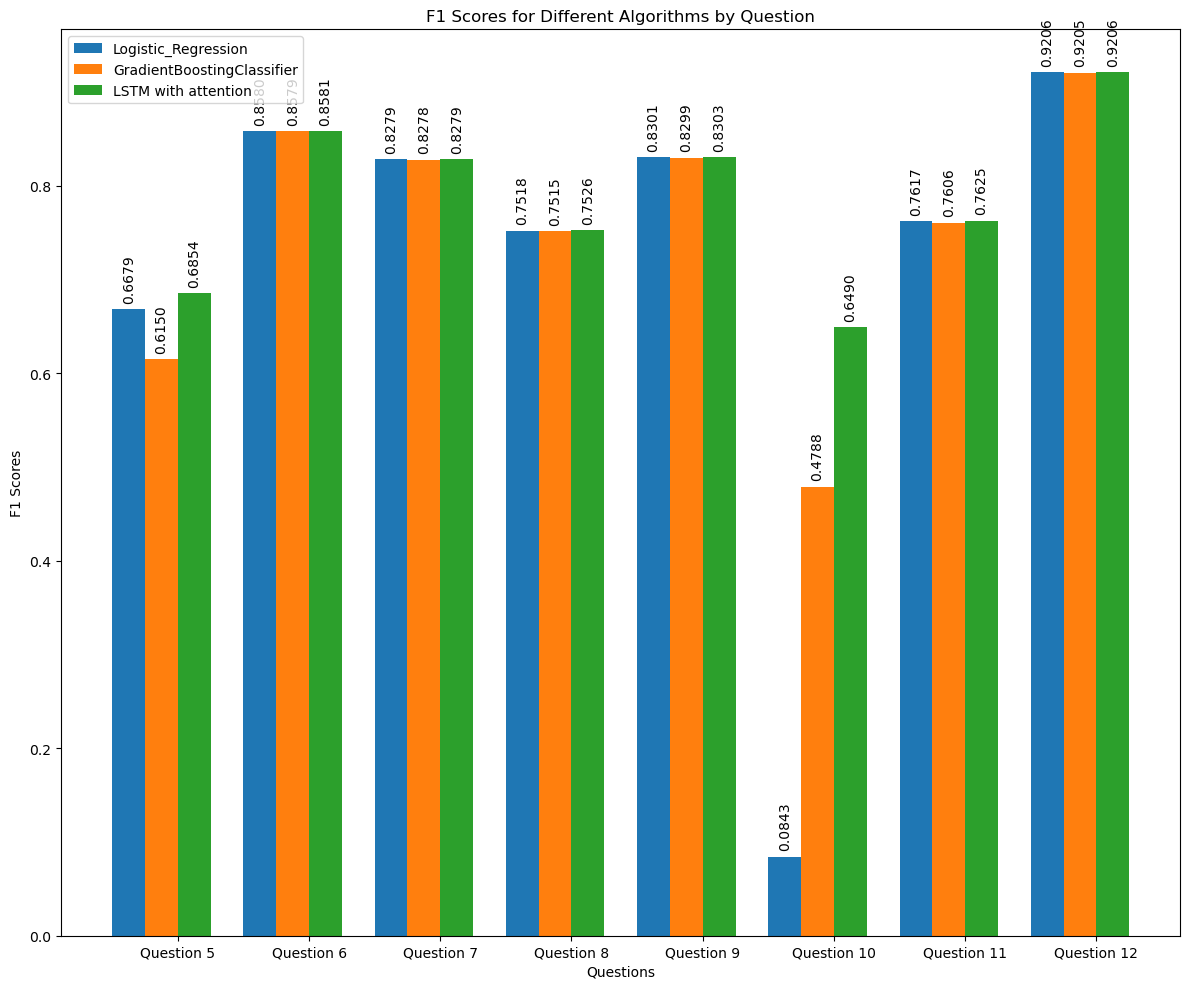

In [52]:
import matplotlib.pyplot as plt
import numpy as np


# Combine all accuracies into a single list
all_f1s = [logreg_f1_scores, gbm_f1_scores, lstm_l1_f1_scores]
modelnames = ['Logistic_Regression', 'GradientBoostingClassifier', 'LSTM with attention']
# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Create x values for the bars
x = np.arange(1, len(logreg_accuracies) + 1)

# Width of each bar
bar_width = 0.25

# Plotting each question's accuracy values for each algorithm
for i in range(len(all_f1s)):
    ax.bar(x + i * bar_width, all_f1s[i], width=bar_width, label=f'{modelnames[i]}')

    for j, val in enumerate(all_f1s[i]):
        ax.text(x[j] + i * bar_width, val + 0.01, f'{val:.4f}', ha='center', rotation=90)
    
# Set labels and title
ax.set_xlabel('Questions')
ax.set_ylabel('F1 Scores')
ax.set_title('F1 Scores for Different Algorithms by Question')
ax.set_xticks(x + len(all_f1s) * bar_width / 2)
ax.set_xticklabels([f'Question {i+4}' for i in x])
ax.legend()

plt.tight_layout()
plt.show()


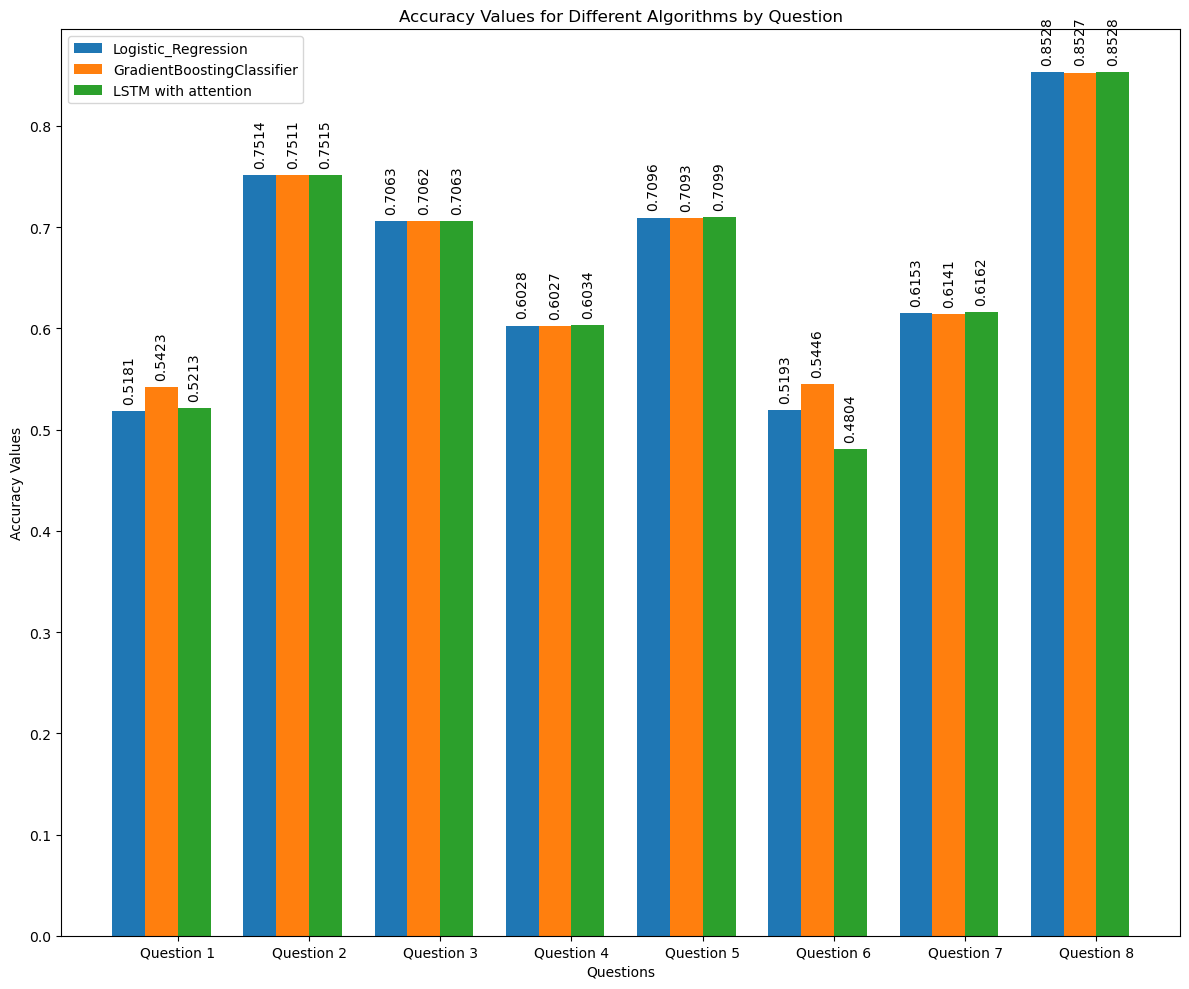

In [54]:
import matplotlib.pyplot as plt
import numpy as np


# Combine all accuracies into a single list
all_accuracies = [logreg_accuracies, gbm_acc, lstm_l1_accuracies]
modelnames = ['Logistic_Regression', 'GradientBoostingClassifier', 'LSTM with attention']
# Plotting
fig, ax = plt.subplots(figsize=(12, 10))

# Create x values for the bars
x = np.arange(1, len(logreg_accuracies) + 1)

# Width of each bar
bar_width = 0.25

# Plotting each question's accuracy values for each algorithm
for i in range(len(all_accuracies)):
    ax.bar(x + i * bar_width, all_accuracies[i], width=bar_width, label=f'{modelnames[i]}')
    for j, val in enumerate(all_accuracies[i]):
        ax.text(x[j] + i * bar_width, val + 0.01, f'{val:.4f}', ha='center', rotation=90)
# Set labels and title
ax.set_xlabel('Questions')
ax.set_ylabel('Accuracy Values')
ax.set_title('Accuracy Values for Different Algorithms by Question')
ax.set_xticks(x + len(all_accuracies) * bar_width / 2)
ax.set_xticklabels([f'Question {i}' for i in x])
ax.legend()

plt.tight_layout()
plt.show()
